In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from evaluation_utils.hdf5_to_df import  HDF5Keys, convert_hdf5_to_viewdict
from evaluation_utils.evaluation_utils import *
import evaluation_utils.pricing as BatterySim # because i moved to mw_to_kWh method there
import vis_utils
from vis_utils import *
from evaluation_utils import *
import h5py


In [4]:

market_colors = qualitative_colors
import cycler
cc_quali = cycler.cycler(color=qualitative_colors)
cc_div = cycler.cycler(color=diverging_colors)
cc_market = cycler.cycler(color=market_colors)

def eid_to_label(eid: str) -> str:
    if "pid" in eid:
        pid = int(eid.split("pid")[1][0])
        return "Prosumer %d" % (pid, )
    else: 
        return eid.split(".")[-1]

this_dataset="Berlin"

# Vergleich Handelssummen 

In [5]:
from pathlib import PurePath

all_prosumers = False # if true 74/74 Prosumers/consumers, else 32/32
simulation_directory = PurePath("../data/sim_christoph/") if all_prosumers else PurePath("../data/results_32_32")
figure_folder = PurePath("figures/htw_berlin") if all_prosumers else PurePath("figures/htw_berlin_32_32")

num_prosumer, num_consumer = (74 , 74) if all_prosumers else (32, 32)
sim_name = "from_2010-01-01_to_2010-12-29_ConProPV_(%d, %d, 0)_%s.hdf5" % (num_prosumer, num_consumer, "%s")
def create_sim_file_name(specifier):
    return PurePath(simulation_directory, sim_name % specifier)

simulation_file_paths =  {
    "No Battery": create_sim_file_name("NoBattery_0Wh"),
    "Simple Battery": create_sim_file_name("SimpleBattery_10000Wh"),
    "SARIMA Smart Battery": create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_10000Wh"),
 #   "Perfect Smart Battery ": create_sim_file_name("CSV_perfect_SmartBattery_10000Wh") ,
}

simulation_file_paths_5kWh =  {
    "No Battery": create_sim_file_name("NoBattery_0Wh"),
    "Simple Battery": create_sim_file_name("SimpleBattery_5000Wh"),
    "SARIMA Smart Battery": create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_5000Wh"), 
   # "Perfect Smart Battery ": create_sim_file_name("CSV_perfect_SmartBattery_5000Wh") ,
}

simulation_dataframes = map_dict_values(simulation_file_paths, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))
simulation_dataframes_5kWh = map_dict_values(simulation_file_paths_5kWh, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))




In [6]:
simulation_dataframes_5kWh["SARIMA Smart Battery"]["Series/Rust_Sim-0.pid0_prosumer_0"][HDF5Keys.ENERGY_BALANCE][()]

array([-15.,  -8.,  -6., ..., -10., -19., -13.])

In [7]:
simulation_dataframes_5kWh["SARIMA Smart Battery"]["Series/Rust_Sim-0.consumer_0"]

<HDF5 group "/Series/Rust_Sim-0.consumer_0" (7 members)>

In [8]:
def sarima_model_str(ar, i, ma, p, q, d) -> str:
    return "CSV_(%d, %d, %d)_(%d, %d, %d, 24)_history_4_SmartBattery_10000Wh" %(ar, i, ma, p, q,d)


KEY_PERFECT = "Perfect"
KEY_B24 = "B24"
KEY_SARIMA_101 = "$(1,0,1)\\times (1,0,1)24$"
KEY_SARIMA_200 = "$(1,0,1)\\times (2,0,0)24$"

simulation_files_model_comparison =  {
    KEY_PERFECT: create_sim_file_name('CSV_perfect_SmartBattery_10000Wh'), 
    KEY_B24: create_sim_file_name('CSV_backschift_24h_SmartBattery_10000Wh'),
    KEY_SARIMA_101: create_sim_file_name(sarima_model_str(1,0,1,1,0,1)),
    KEY_SARIMA_200: create_sim_file_name(sarima_model_str(1,0,1,2,0,0)), 
}
simulation_dataframes_model_comparison = map_dict_values(simulation_files_model_comparison, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))


**Notiz: Durch die Rundungsfehler in enerDAG wird in enerdag etwas zu wenig energie auf dem Markt nachgefragt**:

In [9]:
mw_consumption_to_kwh = sum(list(map(lambda x: BatterySim.mW_to_kWh(x, 300.), simulation_dataframes["No Battery"]['Series/Rust_Sim-0.consumer_0'][HDF5Keys.CONSUMPTION][()])))
published_balance = simulation_dataframes["No Battery"]['Series/Rust_Sim-0.consumer_0'][HDF5Keys.PUBLISHED_BALANCE][()].sum() / 1000.
print("%.2f vs. %.2f" % (mw_consumption_to_kwh, -published_balance))

5094.52 vs. 5042.38


In [10]:
simulation_dataframes.keys()

dict_keys(['No Battery', 'Simple Battery', 'SARIMA Smart Battery'])

In [11]:
p0 = simulation_dataframes["SARIMA Smart Battery"]['Series/Rust_Sim-0.pid0_prosumer_0']
p0eb = p0[HDF5Keys.ENERGY_BALANCE][()].sum() / 1000
p0_eb2 = ((lambda x: BatterySim.mW_to_kWh(x, 300.))(p0[HDF5Keys.CONSUMPTION][()])).sum() - (lambda x: BatterySim.mW_to_kWh(x, 300.))(p0[HDF5Keys.PRODUCTION][()]).sum()
p0_eb2, p0eb

(-5931.742266666309, 5942.281)

In [12]:


smart_bat = consumers_buy_from(simulation_dataframes["SARIMA Smart Battery"]['Series/Rust_Sim-0.consumer_0'])
simple_bat = consumers_buy_from(simulation_dataframes["Simple Battery"]['Series/Rust_Sim-0.consumer_0'])
no_bat = consumers_buy_from(simulation_dataframes["No Battery"]['Series/Rust_Sim-0.consumer_0'])
print("Smart Battery", smart_bat, sum(smart_bat))
print("Simple Battery", simple_bat, sum(simple_bat))
print("No Battery", no_bat, sum(no_bat))

Smart Battery (-1666456, -3120195) -4786651
Simple Battery (-1798312, -6141176) -7939488
No Battery (-1699729, -3342649) -5042378


In [13]:
consumer_buy_balances = map_dict_values(simulation_dataframes, get_consumers_and_calc_buy_from)

consumer_buy_balances_5kWh = map_dict_values(simulation_dataframes_5kWh, get_consumers_and_calc_buy_from)
consumer_buy_balances

{'No Battery': (-44074372, -96516871),
 'Simple Battery': (-31611294, -108979949),
 'SARIMA Smart Battery': (-55514874, -85076369)}

In [14]:
for key, val in consumer_buy_balances.items():
    print(key, val, sum(val))

No Battery (-44074372, -96516871) -140591243
Simple Battery (-31611294, -108979949) -140591243
SARIMA Smart Battery (-55514874, -85076369) -140591243


# Konsumenten können mit Smart Battery bedeutend mehr Energie vom P2P Markt kaufen.

No Battery
	 [0.3134930103719191, 0.6865069896280809]
Simple Battery
	 [0.22484539808784534, 0.7751546019121547]
SARIMA Smart Battery
	 [0.39486722512297584, 0.6051327748770242]


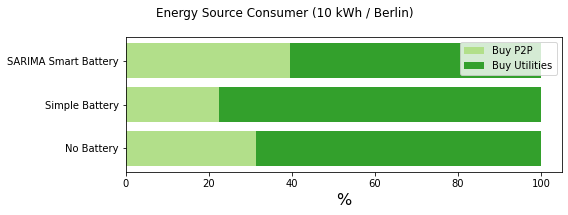

In [15]:
plot_energy_source_consumers(consumer_buy_balances, PurePath(figure_folder, "consumers_buy_from.png"), battery_size=10, dataset="Berlin")
give_percentages_to_horizontal_bar(consumer_buy_balances)

No Battery
	 [0.3134930103719191, 0.6865069896280809]
Simple Battery
	 [0.23461116991475778, 0.7653888300852423]
SARIMA Smart Battery
	 [0.32735778571927127, 0.6726422142807287]


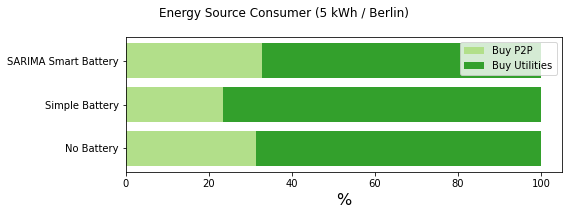

In [16]:
plot_energy_source_consumers(consumer_buy_balances_5kWh, PurePath(figure_folder, "consumers_buy_from_5kWh.png"), battery_size=5, dataset="Berlin")
give_percentages_to_horizontal_bar(consumer_buy_balances_5kWh)

In [50]:
prosumers_sell_balance = map_dict_values(simulation_dataframes, nbhd_prosumers_sell_to)
prosumers_sell_balance_5kWh = map_dict_values(simulation_dataframes_5kWh, nbhd_prosumers_sell_to)
prosumers_sell_balance

{'No Battery': (44074372, 49030048),
 'Simple Battery': (31611294, 61478222),
 'SARIMA Smart Battery': (55514874, 37866845)}

In [51]:
for key, val in prosumers_sell_balance.items():
    print(key, val, sum(val))

No Battery (44074372, 49030048) 93104420
Simple Battery (31611294, 61478222) 93089516
SARIMA Smart Battery (55514874, 37866845) 93381719


# Prosumenten können mit Smart Battery mehr Energie an den P2P Markt verkaufen

No Battery
	 [0.473386462210924, 0.5266135377890759]
Simple Battery
	 [0.3395795290202175, 0.6604204709797825]
SARIMA Smart Battery
	 [0.5944940251099897, 0.40550597489001033]


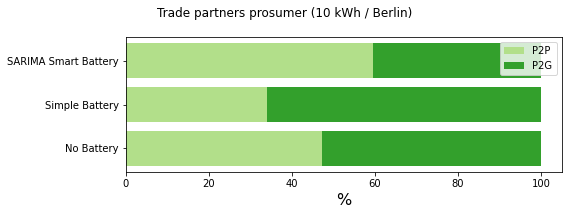

In [18]:
plot_energy_buyer_prosumer(prosumers_sell_balance, PurePath(figure_folder, "prosumers_sell_to.png"), battery_size=10, dataset=this_dataset)
give_percentages_to_horizontal_bar(prosumers_sell_balance)

No Battery
	 [0.473386462210924, 0.5266135377890759]
Simple Battery
	 [0.35428518165325523, 0.6457148183467448]
SARIMA Smart Battery
	 [0.49361746334163825, 0.5063825366583617]


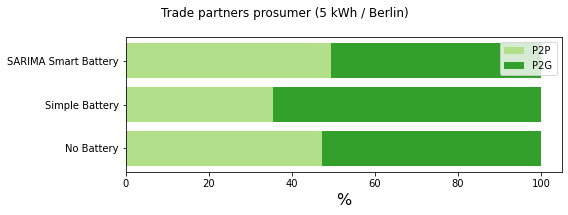

In [19]:
plot_energy_buyer_prosumer(prosumers_sell_balance_5kWh, PurePath(figure_folder, "prosumers_sell_to_5kWh.png"), battery_size=5, dataset=this_dataset)
give_percentages_to_horizontal_bar(prosumers_sell_balance_5kWh)

# Woher beziehen Prosumenten Ihre Energie?
Prosumenten müssen bei der Smart Battery nur unwesentlich mehr Energie vom Netz kaufen.

In [20]:
prosumers_energy_sources = map_dict_values(simulation_dataframes, filter_eid_and_get_energy_source)
nbhd_energy_source = map_dict_values(simulation_dataframes, nbhd_prosumers_energy_sources)
nbhd_energy_source_5kWh = map_dict_values(simulation_dataframes_5kWh, nbhd_prosumers_energy_sources)

No Battery: Adding 31.34 to P2G
No Battery: Adding 31.69 to P2G
No Battery: Adding 36.70 to P2G
No Battery: Adding 45.50 to P2G
No Battery: Adding 33.49 to P2G
No Battery: Adding 32.62 to P2G
No Battery: Adding 32.25 to P2G
No Battery: Adding 42.14 to P2G
No Battery: Adding 34.84 to P2G
No Battery: Adding 34.00 to P2G
No Battery: Adding 32.99 to P2G
No Battery: Adding 33.09 to P2G
No Battery: Adding 36.32 to P2G
No Battery: Adding 34.25 to P2G
No Battery: Adding 35.32 to P2G
No Battery: Adding 34.53 to P2G
No Battery: Adding 35.65 to P2G
No Battery: Adding 38.07 to P2G
No Battery: Adding 34.12 to P2G
No Battery: Adding 32.48 to P2G
No Battery: Adding 33.73 to P2G
No Battery: Adding 35.90 to P2G
No Battery: Adding 37.28 to P2G
No Battery: Adding 32.30 to P2G
No Battery: Adding 39.27 to P2G
No Battery: Adding 30.93 to P2G
No Battery: Adding 30.83 to P2G
No Battery: Adding 32.91 to P2G
No Battery: Adding 31.26 to P2G
No Battery: Adding 32.89 to P2G
No Battery: Adding 34.96 to P2G
No Batte

No Battery
	 [0.3545845997486397, 0.0, 0.03869571795275947, 0.6067196822986008]
Simple Battery
	 [0.3545845997486441, 0.3530005287982374, 0.004449487572650753, 0.2879653838804679]
SARIMA Smart Battery
	 [0.35458459974864326, 0.3154995733715453, 0.016645938929306495, 0.313269887950505]


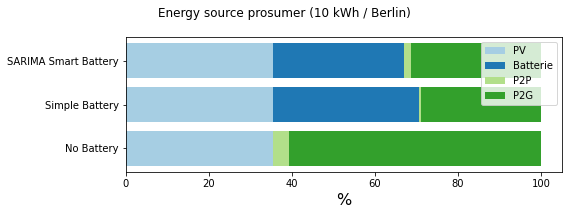

In [21]:
plot_energy_source_prosumers(nbhd_energy_source, PurePath(figure_folder, "prosumers_energy_from.png"), 10, this_dataset)
give_percentages_to_horizontal_bar(nbhd_energy_source)

In [22]:
for key in prosumers_energy_sources:
    print(key)
    t = prosumers_energy_sources[key][0]
    print(t)
    print(sum(t[1]))

No Battery
('Series/Rust_Sim-0.pid0_prosumer_0', (1327.575374444491, 0.0, 40.14000000000001, 1851.1301588893377))
3218.845533333829
Simple Battery
('Series/Rust_Sim-0.pid0_prosumer_0', (1327.575374444491, 1569.7531588892857, 0.0, 321.51700000000005))
3218.845533333777
SARIMA Smart Battery
('Series/Rust_Sim-0.pid0_prosumer_0', (1327.575374444491, 1361.8011588892991, 1.393, 528.076))
3218.84553333379


No Battery
	 [0.3545845997486397, 0.0, 0.03869571795275947, 0.6067196822986008]
Simple Battery
	 [0.3545845997486426, 0.27184076055057327, 0.00555779330057168, 0.3680168464002124]
SARIMA Smart Battery
	 [0.35458459974864037, 0.21677322318254874, 0.014510612083626109, 0.4141315649851847]


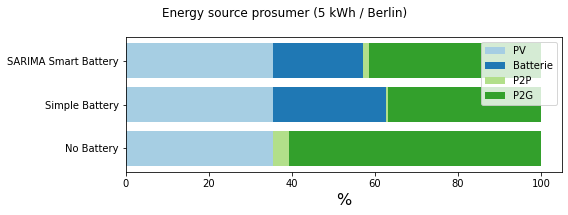

In [23]:
plot_energy_source_prosumers(nbhd_energy_source_5kWh, PurePath(figure_folder, "prosumers_energy_from_5kWh.png"), 5, this_dataset)
give_percentages_to_horizontal_bar(nbhd_energy_source_5kWh)

In [24]:
nbhd_energy_source_5kWh

{'No Battery': [54981.924454648244, 0.0, 6000.161999999999, 94078.01625038801],
 'Simple Battery': [54981.924454648244,
  42151.65625038671,
  861.792,
  57064.73000000002],
 'SARIMA Smart Battery': [54981.924454648244,
  33612.878250387694,
  2250.0170000000003,
  64215.28300000002]}

In [25]:
nbhd_energy_source_prediction_models = map_dict_values(simulation_dataframes_model_comparison, nbhd_prosumers_energy_sources)
print(nbhd_energy_source_prediction_models)

{'Perfect': [54981.924454648244, 54184.90525038616, 2233.5800000000004, 43659.693000000014], 'B24': [54981.924454648244, 49707.398250386395, 2643.185, 47727.594999999994], '$(1,0,1)\\times (1,0,1)24$': [54981.924454648244, 49444.127250386424, 2643.0899999999997, 47990.961], '$(1,0,1)\\times (2,0,0)24$': [54981.924454648244, 48921.396250386446, 2581.121, 48575.66100000001]}


## Vergleich Energiebezug aus Batterie 
Der Vergleich ist in Prozent zum Anteil der Energie die im Pefekten Modell aus der Batterie entnommen werden kann. 
Für den Vergleich mit der insgesamt konsumierten Energie hat $(1, 0, 2) \times (0,0,2)_{24 } \approx 1.1\%$ und $UEMA(168,0.8) \approx 2.5\%$

{'B24': -8.263384385945484, '$(1,0,1)\\times (1,0,1)24$': -8.749259555023306, '$(1,0,1)\\times (2,0,0)24$': -9.713976569078161}


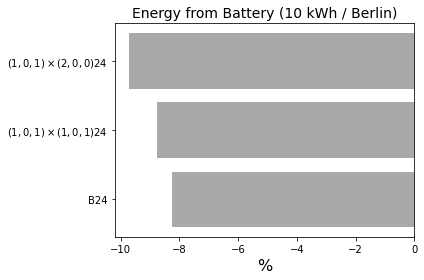

In [26]:
fig_path = PurePath(figure_folder, "prosumers_energy_from_model_comparison.png")
difference = plot_compare_energy_from_battery_to_perfect(nbhd_energy_source_prediction_models, 10, this_dataset, fig_path)
print(difference)

In [27]:
prosumers_sell_balance_comparison = map_dict_values(simulation_dataframes_model_comparison, nbhd_prosumers_sell_to)
prosumers_sell_balance_comparison

{'Perfect': (52539217, 40845084),
 'B24': (55353401, 38050446),
 '$(1,0,1)\\times (1,0,1)24$': (55751825, 37649362),
 '$(1,0,1)\\times (2,0,0)24$': (55514874, 37866845)}

{'B24': 5.356349334250641,
 '$(1,0,1)\\times (1,0,1)24$': 6.114685721334599,
 '$(1,0,1)\\times (2,0,0)24$': 5.663687374709067}

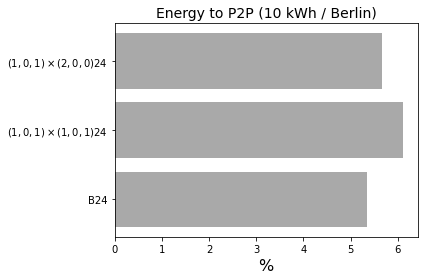

In [28]:
plot_compare_energy_to_p2p_to_perfect(prosumers_sell_balance_comparison, 10, this_dataset,PurePath(figure_folder, "prosumers_energy_sell_to_p2p_comparison.png") )

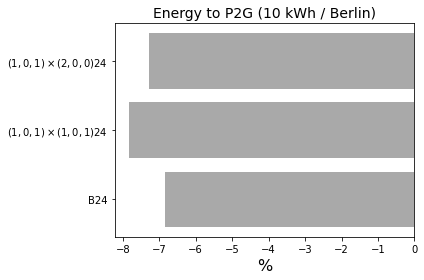

In [29]:
difference = plot_compare_energy_to_p2_grid_to_perfect(prosumers_sell_balance_comparison, 10, this_dataset, None)

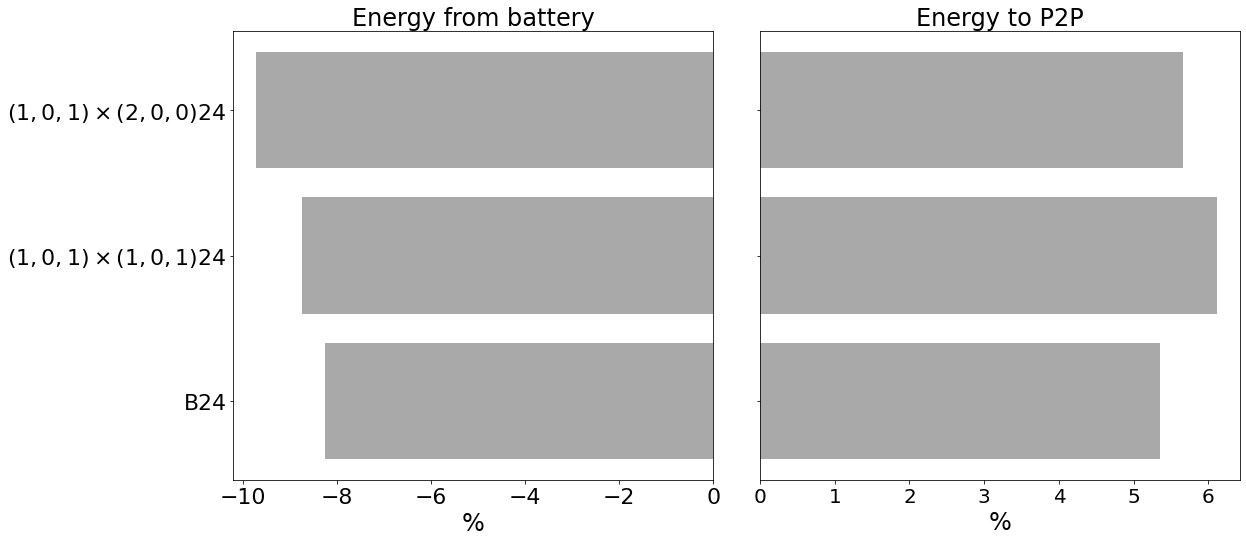

In [30]:
plot_energy_from_bat_and_to_p2p(nbhd_energy_source_prediction_models, prosumers_sell_balance_comparison, this_dataset, 10,PurePath(figure_folder, "prosumers_energy_to_p2p_and_from_battery_large.png") )

In [31]:
give_percentages_to_horizontal_bar(nbhd_energy_source_prediction_models)

Perfect
	 [0.35458459974864387, 0.3494445334752568, 0.014404608026404211, 0.28156625874969504]
B24
	 [0.3545845997486434, 0.320568588458522, 0.01704619662885196, 0.30780061516398266]
$(1,0,1)\times (1,0,1)24$
	 [0.35458459974864337, 0.3188707242406658, 0.017045583963193008, 0.3094990920474979]
$(1,0,1)\times (2,0,0)24$
	 [0.35458459974864326, 0.3154995733715453, 0.016645938929306495, 0.313269887950505]


{'B24': 18.338496942128756, '$(1,0,1)\\times (1,0,1)24$': 18.33424368054868, '$(1,0,1)\\times (2,0,0)24$': 15.559818766285499}


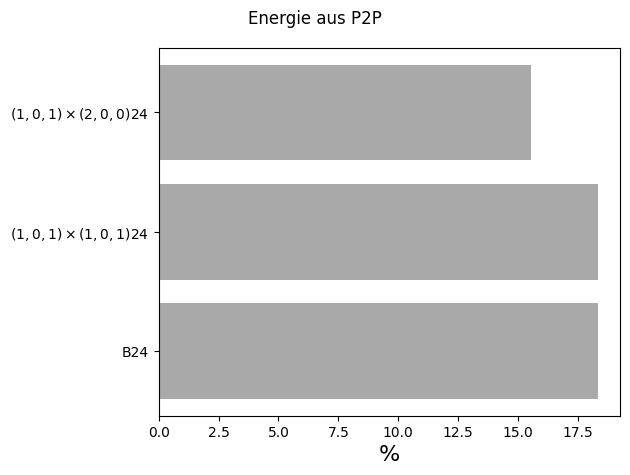

In [32]:
fig, ax = plt.subplots()
print(plot_compare_to_baseline( nbhd_energy_source_prediction_models, "Perfect", 2, ax))
fig.suptitle("Energie aus P2P")
ax.set_xlabel("%", fontsize=16)
fig.tight_layout()

In [33]:
prosumers_energy_sources_model_comparison = map_dict_values(simulation_dataframes_model_comparison, filter_eid_and_get_energy_source)

nbhd_energy_sources_model_comparison = map_dict_values(simulation_dataframes_model_comparison, nbhd_prosumers_energy_sources)

In [34]:
for key, val in nbhd_energy_sources_model_comparison.items():
    print(key, sum(val), val)

Perfect 155060.10270503443 [54981.924454648244, 54184.90525038616, 2233.5800000000004, 43659.693000000014]
B24 155060.10270503463 [54981.924454648244, 49707.398250386395, 2643.185, 47727.594999999994]
$(1,0,1)\times (1,0,1)24$ 155060.10270503466 [54981.924454648244, 49444.127250386424, 2643.0899999999997, 47990.961]
$(1,0,1)\times (2,0,0)24$ 155060.1027050347 [54981.924454648244, 48921.396250386446, 2581.121, 48575.66100000001]


Perfect
	 [0.35458459974864387, 0.3494445334752568, 0.014404608026404211, 0.28156625874969504]
B24
	 [0.3545845997486434, 0.320568588458522, 0.01704619662885196, 0.30780061516398266]
$(1,0,1)\times (1,0,1)24$
	 [0.35458459974864337, 0.3188707242406658, 0.017045583963193008, 0.3094990920474979]
$(1,0,1)\times (2,0,0)24$
	 [0.35458459974864326, 0.3154995733715453, 0.016645938929306495, 0.313269887950505]


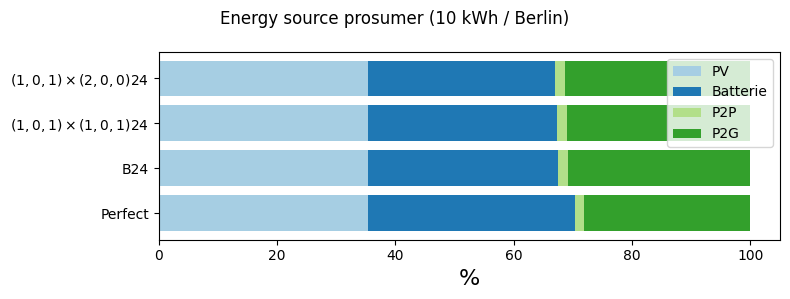

In [35]:
plot_energy_source_prosumers(nbhd_energy_sources_model_comparison, PurePath(figure_folder, "prosumers_energy_from_model_comparison.png"), 10, this_dataset)
give_percentages_to_horizontal_bar(nbhd_energy_sources_model_comparison)

Perfect
	 [0.5626129492579272, 0.4373870507420728]
B24
	 [0.5926244237028053, 0.4073755762971947]
$(1,0,1)\times (1,0,1)24$
	 [0.5969070286012532, 0.4030929713987468]
$(1,0,1)\times (2,0,0)24$
	 [0.5944940251099897, 0.40550597489001033]


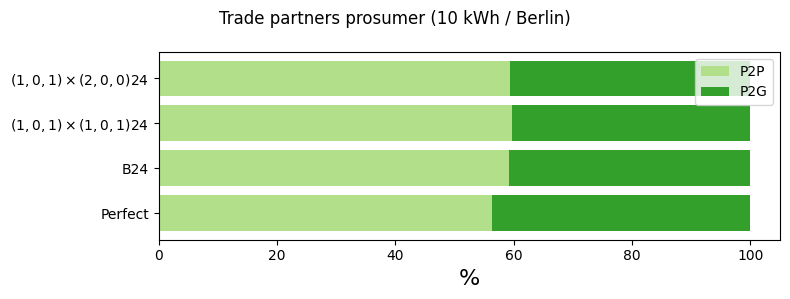

In [36]:
prosumers_sell_balance_model_comparison = map_dict_values(simulation_dataframes_model_comparison, nbhd_prosumers_sell_to)
plot_energy_buyer_prosumer(prosumers_sell_balance_model_comparison, PurePath(figure_folder, "prosumers_sell_to_model_comparison.png"), battery_size=10, dataset=this_dataset)
give_percentages_to_horizontal_bar(prosumers_sell_balance_model_comparison)

## Kombinierte Grafik für Energiequelle und Energieverkauf

In [37]:

nbhd_energy_source_combined = combine_10kWH_5kWh_dict(nbhd_energy_source, nbhd_energy_source_5kWh)
prosumers_sell_balance_combined = combine_10kWH_5kWh_dict(prosumers_sell_balance, prosumers_sell_balance_5kWh)

Simple Battery (10kWh)
	 [0.3395795290202175, 0.6604204709797825]
SARIMA Smart Battery (10kWh)
	 [0.5944940251099897, 0.40550597489001033]
Simple Battery (5kWh)
	 [0.35428518165325523, 0.6457148183467448]
SARIMA Smart Battery (5kWh)
	 [0.49361746334163825, 0.5063825366583617]
No Battery
	 [0.473386462210924, 0.5266135377890759]
Nbhd energy source
Simple Battery (10kWh)
	 [0.3545845997486441, 0.3530005287982374, 0.004449487572650753, 0.2879653838804679]
SARIMA Smart Battery (10kWh)
	 [0.35458459974864326, 0.3154995733715453, 0.016645938929306495, 0.313269887950505]
Simple Battery (5kWh)
	 [0.3545845997486426, 0.27184076055057327, 0.00555779330057168, 0.3680168464002124]
SARIMA Smart Battery (5kWh)
	 [0.35458459974864037, 0.21677322318254874, 0.014510612083626109, 0.4141315649851847]
No Battery
	 [0.3545845997486397, 0.0, 0.03869571795275947, 0.6067196822986008]


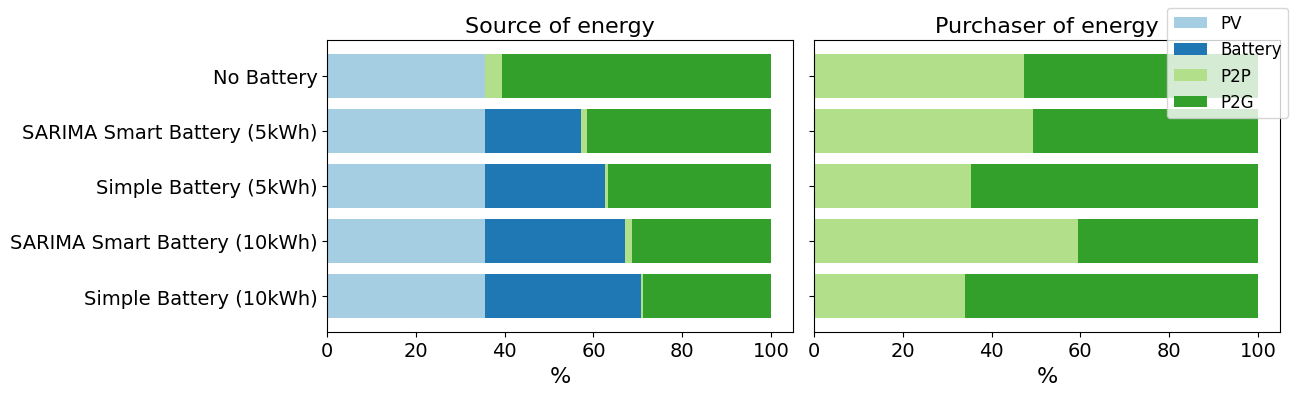

In [38]:
plot_combined_energy_source_sell_to(nbhd_energy_source_combined, prosumers_sell_balance_combined,  this_dataset, PurePath(figure_folder, "prosumers_energy_overview.png"))
give_percentages_to_horizontal_bar(prosumers_sell_balance_combined)

print("Nbhd energy source")
give_percentages_to_horizontal_bar(nbhd_energy_source_combined)


### Grafik für Energiebezug der Konsumenten mit 5kWh / 10kWh Kombiniert

No Battery
	 [0.3134930103719191, 0.6865069896280809]
Simple Battery
	 [0.22484539808784534, 0.7751546019121547]
SARIMA Smart Battery
	 [0.39486722512297584, 0.6051327748770242]
5kwh
No Battery
	 [0.3134930103719191, 0.6865069896280809]
Simple Battery
	 [0.23461116991475778, 0.7653888300852423]
SARIMA Smart Battery
	 [0.32735778571927127, 0.6726422142807287]


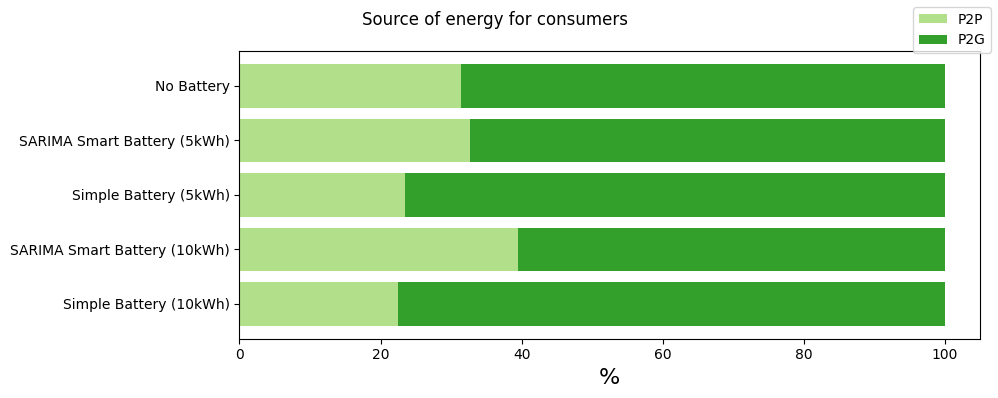

In [65]:
plot_combined_energy_source_consumers(consumer_buy_balances, consumer_buy_balances_5kWh, PurePath(figure_folder, "consumers_buy_from_combined.png"))
give_percentages_to_horizontal_bar(consumer_buy_balances)
print("5kwh")
give_percentages_to_horizontal_bar(consumer_buy_balances_5kWh)


In [40]:
consumers_buy_balances_combined = combine_10kWH_5kWh_dict(consumer_buy_balances, consumer_buy_balances_5kWh,)

Simple Battery (10kWh)
	 [0.22484539808784534, 0.7751546019121547]
SARIMA Smart Battery (10kWh)
	 [0.39486722512297584, 0.6051327748770242]
Simple Battery (5kWh)
	 [0.23461116991475778, 0.7653888300852423]
SARIMA Smart Battery (5kWh)
	 [0.32735778571927127, 0.6726422142807287]
No Battery
	 [0.3134930103719191, 0.6865069896280809]


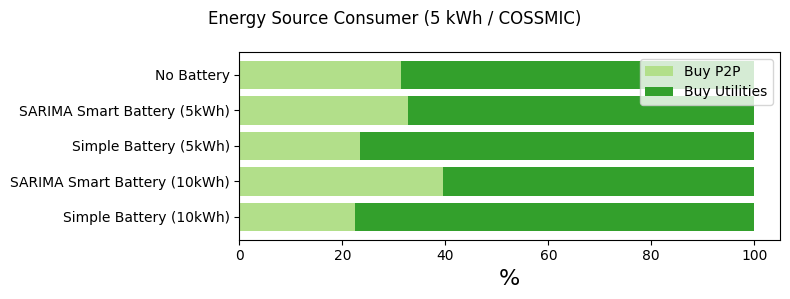

In [41]:
fig, _ = plot_energy_source_consumers(consumers_buy_balances_combined, PurePath(figure_folder, "consumers_buy_from_combined.png"))

give_percentages_to_horizontal_bar(consumers_buy_balances_combined)

## Erstellen von Tabellen
Marktdaten sind in *WH* energiequellen daten sind in kWH deshalt wird weiter unten das nbhd_energy_source_combined mal 1000 genommen damit es nachher beim formatieren in der Zelle wieder stimmt.

In [74]:
def tex_table_from_dict(d: Dict[str, Iterable[float]], sum_on_end =  True, call_on_entry: Callable = lambda x: x) -> str:
    import os
    s = ""
    for key, val in d.items():
      
        s =  "%s%s" % (s, key ,)
        total =  sum(val)
        for price in val:
            s = ("%s & %s" % (s, call_on_entry(price)))
        if sum_on_end:
            s = ("%s & %s" % (s, call_on_entry(total)))
        s = ("%s  \\\\ %s" % (s, os.linesep))
    
    return s
print(tex_table_from_dict(consumers_buy_balances_combined, sum_on_end=False, call_on_entry=lambda x: f"{x / 1000}kWh"))

Simple Battery (10kWh) & -31611.294kWh & -108979.949kWh  \\ 
SARIMA Smart Battery (10kWh) & -55514.874kWh & -85076.369kWh  \\ 
Simple Battery (5kWh) & -32984.276kWh & -107606.967kWh  \\ 
SARIMA Smart Battery (5kWh) & -46023.638kWh & -94567.605kWh  \\ 
No Battery & -44074.372kWh & -96516.871kWh  \\ 



In [81]:
combined_sell_buy_data_prosumers = dict()
for key in nbhd_energy_source_combined:
    # nbhd_energy_source_combined[key])*1000 -> nbhd_energy_source_combined ist schon in kWh, deshalb mal 1000 damit es unten wieder passt.
    combined_sell_buy_data_prosumers[key] = list(np.array(nbhd_energy_source_combined[key])*1000) + list(prosumers_sell_balance_combined[key])
combined_sell_buy_data_prosumers
print(tex_table_from_dict(combined_sell_buy_data_prosumers, sum_on_end=False, call_on_entry=lambda x: f"{x / 1000:.2f}kWh"))

Simple Battery (10kWh) & 54981.92kWh & 54736.30kWh & 689.94kWh & 44651.94kWh & 31611.29kWh & 61478.22kWh  \\ 
SARIMA Smart Battery (10kWh) & 54981.92kWh & 48921.40kWh & 2581.12kWh & 48575.66kWh & 55514.87kWh & 37866.85kWh  \\ 
Simple Battery (5kWh) & 54981.92kWh & 42151.66kWh & 861.79kWh & 57064.73kWh & 32984.28kWh & 60116.64kWh  \\ 
SARIMA Smart Battery (5kWh) & 54981.92kWh & 33612.88kWh & 2250.02kWh & 64215.28kWh & 46023.64kWh & 47213.82kWh  \\ 
No Battery & 54981.92kWh & 0.00kWh & 6000.16kWh & 94078.02kWh & 44074.37kWh & 49030.05kWh  \\ 



# Betrachte die durchschnittliche Handelsbilanz

In [42]:
import h5py
from evaluation_utils.hdf5_to_df import get_marketplace_df, MarketplaceKeys

In [43]:
marketplace_dfs = map_dict_values(simulation_file_paths, lambda x: get_marketplace_df(h5py.File(x)))

In [44]:
for sim, df in marketplace_dfs.items():
    print(sim, "Trades: ", df[MarketplaceKeys.NEIGHBORHOOD_TRADED].mean())

No Battery Trades:  26.98778007980356
Simple Battery Trades:  15.628011817065685
SARIMA Smart Battery Trades:  23.532401012891345


In [45]:
quarters = [pd.date_range(start=pd.Timestamp("2010-01-01 00:00:00"), end=pd.Timestamp("2010-03-31 23:59:59"), freq="5MIN"),
            pd.date_range(start=pd.Timestamp("2010-04-01 00:00:00"),
                          end=pd.Timestamp("2010-06-30 23:59:59"), freq="5MIN"),
            pd.date_range(start=pd.Timestamp("2010-07-01 00:00:00"),
                          end=pd.Timestamp("2010-09-30 23:59:59"), freq="5MIN"),
            pd.date_range(start=pd.Timestamp("2010-10-01 00:00:00"), end=pd.Timestamp("2010-12-28 00:00:00"), freq="5MIN"), ]


for sim, df in marketplace_dfs.items():
    for i, quarter in enumerate(quarters):
        print(sim, "Trades: quarter ",i, df[MarketplaceKeys.NEIGHBORHOOD_TRADED][quarter].mean())
        

No Battery Trades: quarter  0 22.32835648148148
No Battery Trades: quarter  1 33.661973443223445
No Battery Trades: quarter  2 32.35299667874396
No Battery Trades: quarter  3 19.380903531268494
Simple Battery Trades: quarter  0 10.125462962962963
Simple Battery Trades: quarter  1 22.748817155067155
Simple Battery Trades: quarter  2 21.952860809178745
Simple Battery Trades: quarter  3 7.455079897415664
SARIMA Smart Battery Trades: quarter  0 12.100270061728395
SARIMA Smart Battery Trades: quarter  1 34.987484737484735
SARIMA Smart Battery Trades: quarter  2 37.66704408212561
SARIMA Smart Battery Trades: quarter  3 8.858985993292563


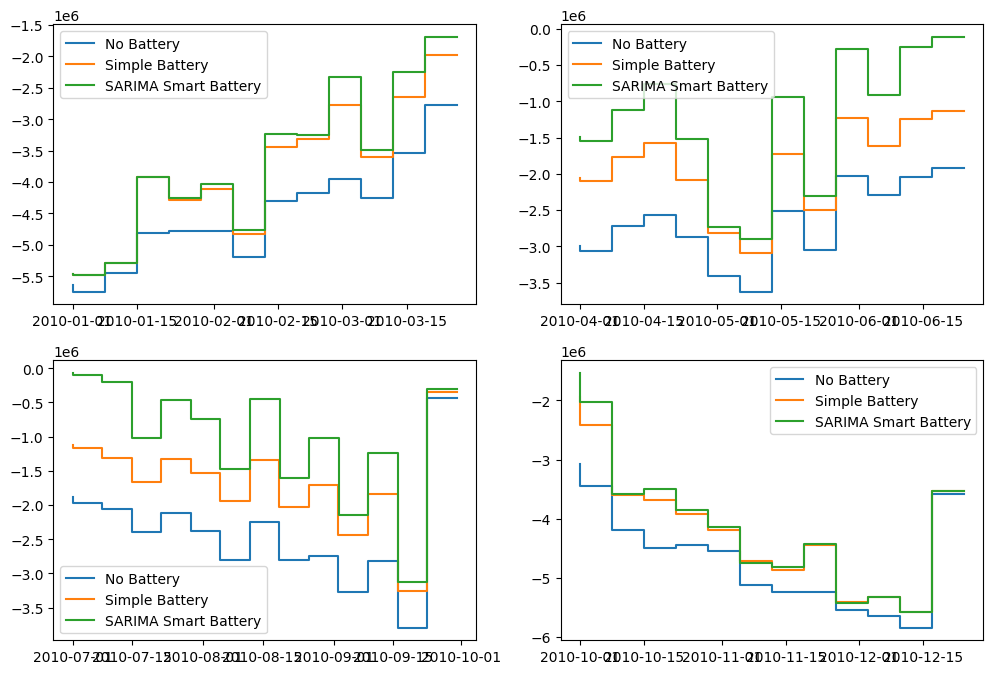

In [46]:
fig, axs = plt.subplots(2,2, figsize=(12,8))


for i, quarter in enumerate(quarters):
    ax = axs[i//2][i%2]    
    for sim, df in marketplace_dfs.items():
        df_quarter = df[MarketplaceKeys.NEIGHBORHOOD_ENERGY_BALANCE][quarter]
        missing_energy = df_quarter[df_quarter < 0]
        weekly = vis_utils.group_by_week(missing_energy, np.sum)
        ax.step(weekly.index, weekly, label=sim)
    ax.legend()    

## Summe der Fehlenden Energie in Handelsrunden

Text(0.5, 0.98, 'Missing energy per week')

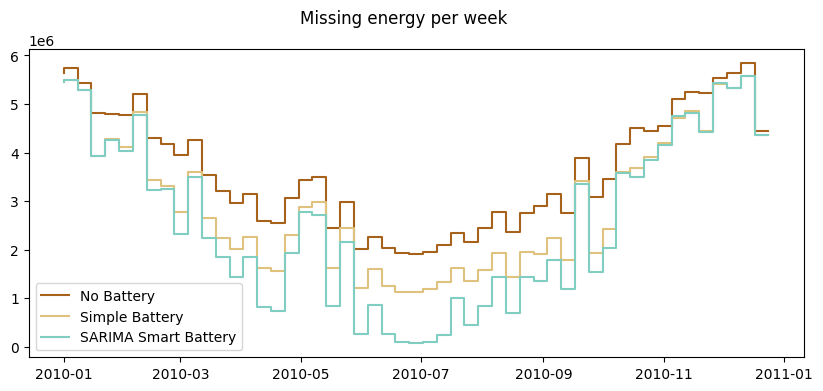

In [47]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_prop_cycle(cc_div)
for sim, df in marketplace_dfs.items():
        nbhd_balance = df[MarketplaceKeys.NEIGHBORHOOD_ENERGY_BALANCE][:pd.Timestamp("2017-01-28")]
        missing_energy = -nbhd_balance[nbhd_balance < 0]
        weekly = vis_utils.group_by_week(missing_energy, np.sum)
        ax.step(weekly.index, weekly, label=sim)
ax.legend()
fig.suptitle("Missing energy per week")

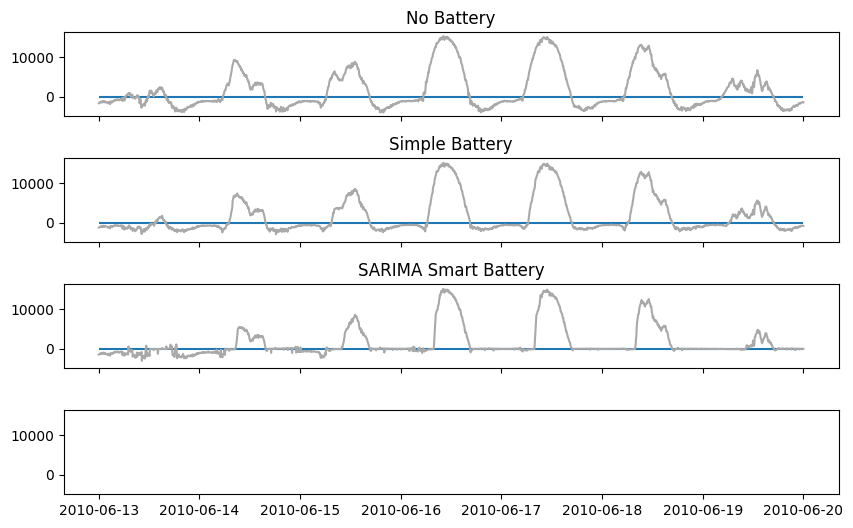

In [48]:
fig, axs = plt.subplots(4,1,figsize=(10,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5)
for i, (sim, df) in enumerate(marketplace_dfs.items()):
    ax = axs[i]
    start = pd.Timestamp('2010-06-13 00:00:00')
    nbhd_balance = df[MarketplaceKeys.NEIGHBORHOOD_ENERGY_BALANCE][start:start + pd.Timedelta(days=7)]
    
    ax.plot(nbhd_balance, 'darkgray')
    ax.hlines(0, min(nbhd_balance.index), max(nbhd_balance.index))

    ax.set_title(sim)

    

In [61]:

def tex_model_costs(prices: Dict[str, List[Tuple[str, float]]]):
    s = ""
    import os
    for model, model_prices in prices.items():
        s =  "%s%s" % (s, model ,)
        total =  sum(map(lambda x: x[1], model_prices))
        for pid, price in model_prices:
            s = ("%s & \\myEUR{%.2f}" % (s, price)).replace(".", ",")
        s = ("%s & \\myEUR{%.2f}" % (s, total)).replace(".", ",")
        s = ("%s  \\\\ %s" % (s, os.linesep))
    
    return 